#### Modeling

What do I want to accomplish in this file?
* focus on installations most similar to target audience
* build first pass model and test

What do I want to predict?  The cost/watt for typical residential solar installation in 4-6 quarters past the end of my data.

__* Also, polynomial models. *__

__*My big idea: model median to get rid of noise.  Model mean for sanity check.*__

* Kick out all the data that doesn't match my customer (roof mounted, direct owner, any locality)

### What's in the model?

what to kick out

* Appraised prices - They're not market price so ignore...
* Only residential prices - Ignore everything else
* Third party owners have some of the same issues as appraised prices - we'll just use direct market prices
* Tracking and ground-mount - not enough to keep in; probably makes no diff for modeling
* Battery - non-typical pricing


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 8))
np.set_printoptions(precision=4, suppress=False)
# please show all columns
pd.set_option("display.max_columns", 60)
import seaborn as sns
sns.set()

# from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures


In [2]:
# read cleaned data
dftts = pd.read_csv('../local/data/LBNL_openpv_tts_data/ttsclean20180127.csv',
                    encoding='iso-8859-1', # avoids windows encoding issue
                    index_col='row_id',
                    parse_dates=['install_date'],
                    dtype={'zipcode' : np.object})



In [3]:
# capture the installation month for each row
# month = dftts.install_date.apply(lambda x: x.to_period('M'))

# save in a new column
# dftts = dftts.assign(install_month=month)

In [4]:
dftts.head()

,file_row,data_provider,sysid_dp,sysid_tts,install_date,size_kw,price,appraised_value,cust_type,new_const,tracking,ground_mounted,battery,zipcode,city,county,state,third-party,uinverter,dc_optimizer,cost_per_watt,num_days
row_id,,,,,,,,,,,,,,,,,,,,,,
1,10108220,California Public Utilities Commission (Curren...,PGE-INT-11328 & CA_ERP_24698,CA-NEM-12257,1998-01-09,2.2824,24500.00,False,RES,False,False,False,False,94107.0,San Francisco,San Francisco,CA,False,False,False,10.734315,0
2,10107162,California Public Utilities Commission (Curren...,PGE-INT-11220 & CA_ERP_24687,CA-NEM-11180,1998-01-30,1.8504,20555.54,False,RES,False,False,False,False,95949.0,Nevada City,Nevada,CA,False,False,False,11.108701,21
4,10107618,California Public Utilities Commission (Curren...,PGE-INT-11268 & CA_ERP_24540,CA-NEM-11641,1998-02-04,2.3076,20000.00,False,RES,False,False,False,False,94518.0,Concord,Contra Costa,CA,False,False,False,8.667013,26
6,10107745,California Public Utilities Commission (Curren...,PGE-INT-11280 & CA_ERP_24429,CA-NEM-11770,1998-04-03,2.3316,30941.00,False,RES,False,False,False,False,94038.0,Moss Beach,San Mateo,CA,False,False,False,13.270286,84
7,10107787,California Public Utilities Commission (Curren...,PGE-INT-11284 & CA_ERP_24701,CA-NEM-11812,1998-04-30,0.9300,13629.00,False,RES,False,False,False,False,94563.0,Orinda,Contra Costa,CA,False,False,False,14.654839,111


#### remove irrelevant data
* first let's restrict to residential


In [5]:
# only residential
dfMod = dftts[dftts.cust_type == 'RES']
print(len(dfMod))

745688


In [6]:
# only market price
dfMod = dfMod[dfMod.appraised_value == False]
print(len(dfMod))

519079


In [7]:
dfMod.columns

Index(['file_row', 'data_provider', 'sysid_dp', 'sysid_tts', 'install_date',
       'size_kw', 'price', 'appraised_value', 'cust_type', 'new_const',
       'tracking', 'ground_mounted', 'battery', 'zipcode', 'city', 'county',
       'state', 'third-party', 'uinverter', 'dc_optimizer', 'cost_per_watt',
       'num_days'],
      dtype='object')

In [8]:
# only direct owership
dfMod = dfMod[dfMod['third-party'] == False]
print(len(dfMod))

374091


In [9]:
# no batteries
dfMod = dfMod[dfMod['battery'] == False]
print(len(dfMod))

373936


In [10]:
# no ground mount
dfMod = dfMod[dfMod['ground_mounted'] == False]
print(len(dfMod))

365585


(0, 40)

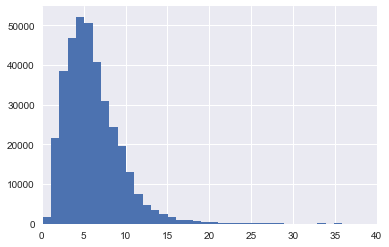

In [11]:
# almost all of them are less than 25kw
plt.hist(dfMod.size_kw, bins=2000)
plt.xlim(0,40)

In [12]:
### what is mean and median size_kw
dfMod[['size_kw']].describe()

,size_kw
count,365585.000000
mean,6.250930
std,7.931703
min,0.108000
25%,3.750000
50%,5.520000
75%,7.800000
max,1989.520000


In [13]:
### how many are over 25kw; only 1.4k
(dfMod.size_kw > 25).sum()

1359

In [14]:
### we can live without those big installs; they are in no way typical.
dfMod = dfMod[dfMod['size_kw'] < 25]
print(len(dfMod))

364212


In [15]:
dfMod.head()

,file_row,data_provider,sysid_dp,sysid_tts,install_date,size_kw,price,appraised_value,cust_type,new_const,tracking,ground_mounted,battery,zipcode,city,county,state,third-party,uinverter,dc_optimizer,cost_per_watt,num_days
row_id,,,,,,,,,,,,,,,,,,,,,,
1,10108220,California Public Utilities Commission (Curren...,PGE-INT-11328 & CA_ERP_24698,CA-NEM-12257,1998-01-09,2.2824,24500.00,False,RES,False,False,False,False,94107.0,San Francisco,San Francisco,CA,False,False,False,10.734315,0
2,10107162,California Public Utilities Commission (Curren...,PGE-INT-11220 & CA_ERP_24687,CA-NEM-11180,1998-01-30,1.8504,20555.54,False,RES,False,False,False,False,95949.0,Nevada City,Nevada,CA,False,False,False,11.108701,21
4,10107618,California Public Utilities Commission (Curren...,PGE-INT-11268 & CA_ERP_24540,CA-NEM-11641,1998-02-04,2.3076,20000.00,False,RES,False,False,False,False,94518.0,Concord,Contra Costa,CA,False,False,False,8.667013,26
6,10107745,California Public Utilities Commission (Curren...,PGE-INT-11280 & CA_ERP_24429,CA-NEM-11770,1998-04-03,2.3316,30941.00,False,RES,False,False,False,False,94038.0,Moss Beach,San Mateo,CA,False,False,False,13.270286,84
7,10107787,California Public Utilities Commission (Curren...,PGE-INT-11284 & CA_ERP_24701,CA-NEM-11812,1998-04-30,0.9300,13629.00,False,RES,False,False,False,False,94563.0,Orinda,Contra Costa,CA,False,False,False,14.654839,111


### I'm done throwing things out.  Probably be a good idea to drop the columns that I'm not using anymore...

In [16]:
np.max(dfMod.size_kw)

24.99

In [17]:
['file_row', 'data_provider', 'sysid_dp', 'sysid_tts', 'install_date',
       'size_kw', 'price', 'appraised_value', 'cust_type', 'new_const',
       'tracking', 'ground_mounted', 'battery', 'zipcode', 'city', 'county',
       'state', 'third-party', 'uinverter', 'dc_optimizer', 'cost_per_watt',
       'num_days', 'install_month'];

#### Stop carrying around all the baggage

In [18]:
dfMod = dfMod[['num_days', 'size_kw', 'state', 'cost_per_watt', 'install_date']]

In [19]:
scaleSize = dfMod.size_kw/2.5

In [20]:
scaleSize = scaleSize.astype(np.int)

In [21]:
dfMod = dfMod.assign(scaleSize=scaleSize)

In [22]:
dfMod[['scaleSize']].describe()

,scaleSize
count,364212.000000
mean,1.928089
std,1.327916
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,9.000000


### This is really all the data I need for modeling (with some caveats)

1. scaleSize and size_kw are the same info (pretty much)
2. state could be (should be?) a categorical variable 
1. variables are not normalized
1. could drop all the states except the top 5(?).  How much data would I lose?  13%.   It would simplify the model for polynomial features (19 states to 5 states)

In [23]:
dfMod.state.value_counts()

CA    222666
AZ     29667
NY     28068
MA     24532
TX     13288
NJ      6611
PA      6197
NM      6028
CT      5543
MD      5460
NH      2850
NV      2723
VT      2133
OR      2036
DE      1984
WI      1930
FL      1647
MN       781
AR        68
Name: state, dtype: int64

In [24]:
dfMod.state.map(lambda x: x in ['CA', 'AZ', 'NY', 'MA', 'TX']).sum()

318221

In [25]:
_/len(dfMod)

0.8737246438887242

In [26]:
dfMod.to_csv('../local/data/LBNL_openpv_tts_data/ModelData.csv')

In [27]:
dfMod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364212 entries, 1 to 1094908
Data columns (total 6 columns):
num_days         364212 non-null int64
size_kw          364212 non-null float64
state            364212 non-null object
cost_per_watt    364212 non-null float64
install_date     364212 non-null datetime64[ns]
scaleSize        364212 non-null int32
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(1)
memory usage: 18.1+ MB


In [28]:
dfMod.head()

,num_days,size_kw,state,cost_per_watt,install_date,scaleSize
row_id,,,,,,
1,0,2.2824,CA,10.734315,1998-01-09,0
2,21,1.8504,CA,11.108701,1998-01-30,0
4,26,2.3076,CA,8.667013,1998-02-04,0
6,84,2.3316,CA,13.270286,1998-04-03,0
7,111,0.9300,CA,14.654839,1998-04-30,0


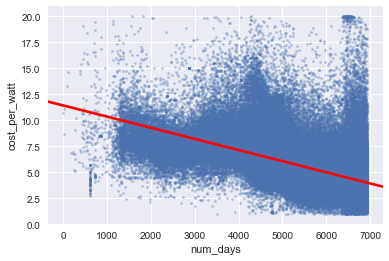

In [29]:
sns.regplot('num_days', 'cost_per_watt', dfMod, 
          scatter_kws={'alpha' : 0.4, 's' : 7},
          line_kws={'color' : 'red'} )

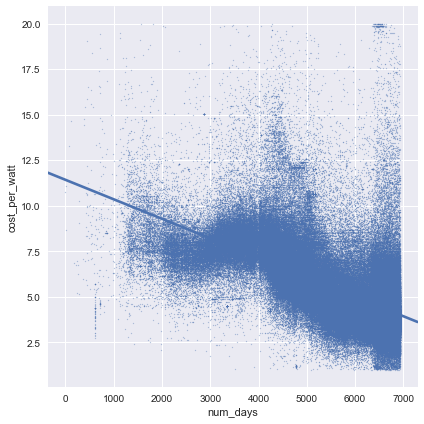

In [30]:
sns.lmplot('num_days', 'cost_per_watt', dfMod, 
           size=6, markers='.', scatter_kws={'alpha' : 0.4, 's' : 7})

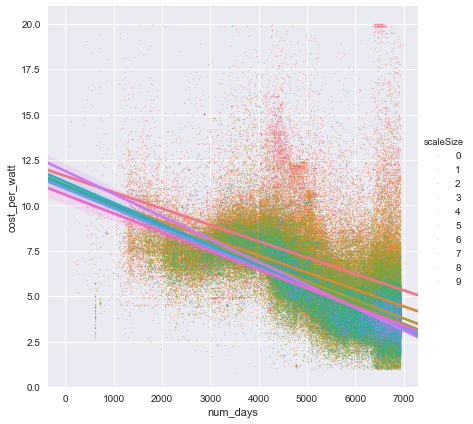

In [31]:
sns.lmplot('num_days', 'cost_per_watt', dfMod, 
           hue = 'scaleSize',
           size=6, markers='.', scatter_kws={'alpha' : 0.4, 's' : 7})

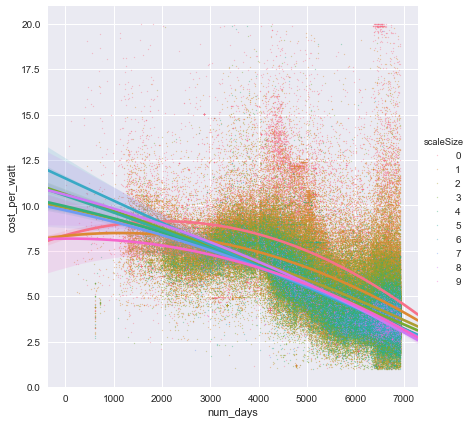

In [32]:
# takes a while
# try quadratic
sns.lmplot('num_days', 'cost_per_watt', dfMod, 
           hue = 'scaleSize', order=2,
           size=6, markers='.', scatter_kws={'alpha' : 0.4, 's' : 7})

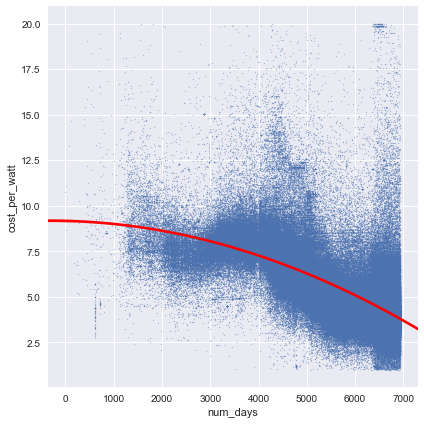

In [33]:
# takes a while
# try quadratic
sns.lmplot('num_days', 'cost_per_watt', dfMod, 
           order=2,
           size=6, markers='.', 
           scatter_kws={'alpha' : 0.4, 's' : 7},
           line_kws={'color' : 'red'} )

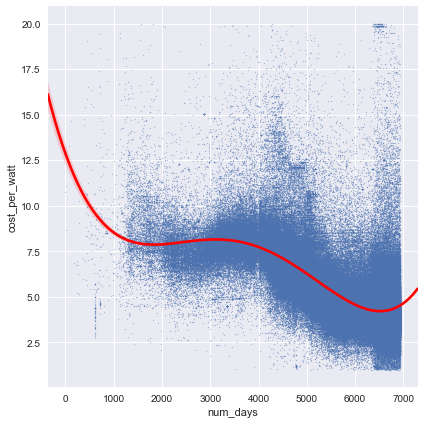

In [34]:
# try 4th degree polynomial but don't color by size
sns.lmplot('num_days', 'cost_per_watt', dfMod, 
           order=4,
           size=6, markers='.',
           scatter_kws={'alpha' : 0.4, 's' : 7},
           line_kws={'color' : 'red'} )

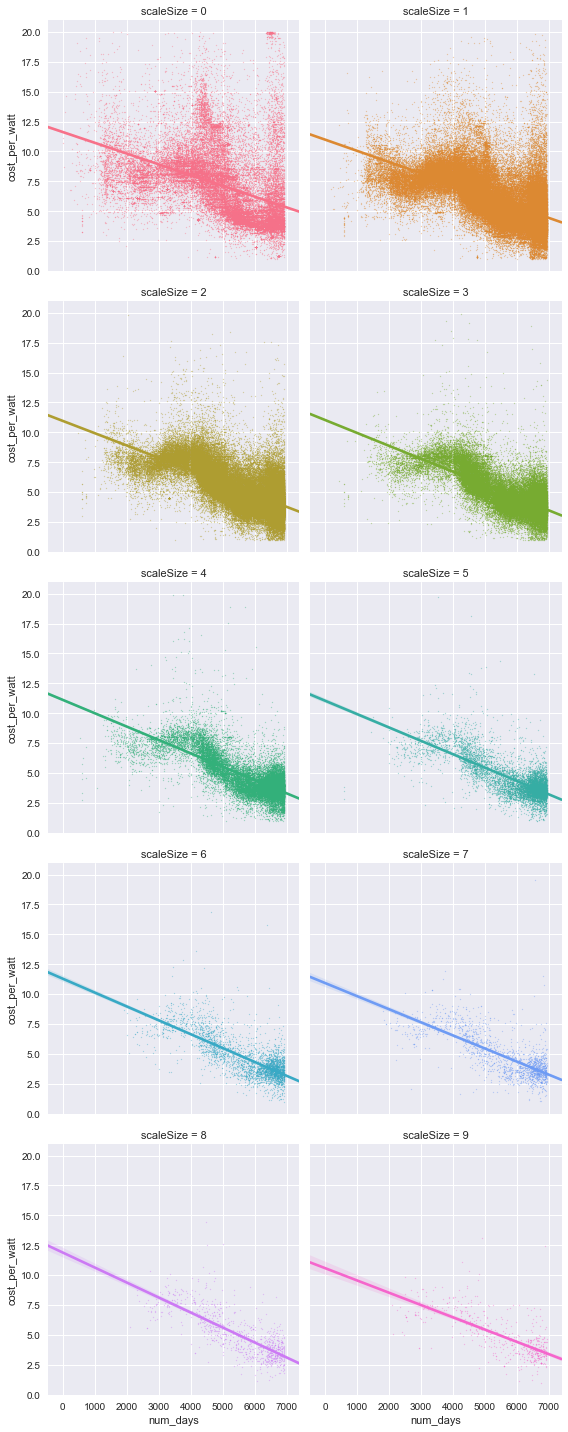

In [35]:
sns.lmplot('num_days', 'cost_per_watt', dfMod, 
           hue = 'scaleSize', col='scaleSize', col_wrap=2,
           size=4, markers='.', scatter_kws={'alpha' : 0.4, 's' : 7})

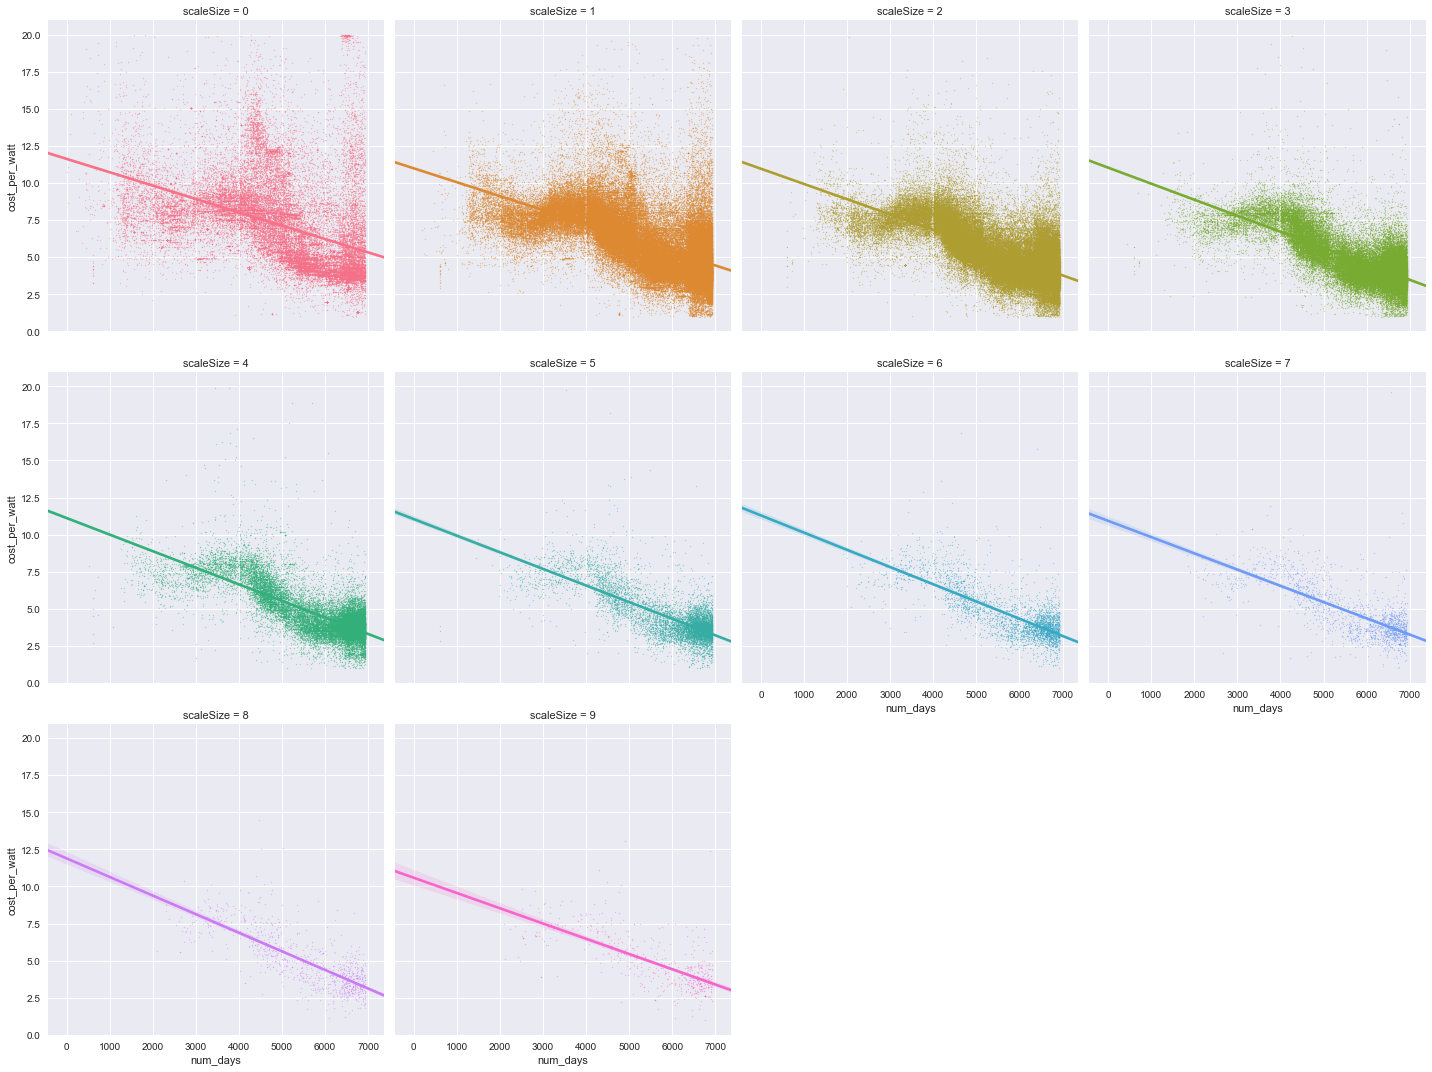

In [36]:
sns.lmplot('num_days', 'cost_per_watt', dfMod, 
           hue = 'scaleSize', col='scaleSize', col_wrap=4,
           size=5, markers='.', scatter_kws={'alpha' : 0.4, 's' : 7})

In [37]:
# what's the mean and median size for residential
dfMod[['size_kw']].describe()

,size_kw
count,364212.000000
mean,6.042169
std,3.228693
min,0.108000
25%,3.744000
50%,5.500000
75%,7.750000
max,24.990000


In [38]:
# rename annoying row
dfMod.rename(index=str, columns={"third-party": "third_party"}, inplace=True)

### use statsmodels to do linear regression

In [39]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

C:\Users\saus\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [40]:
m0 = ols('cost_per_watt ~ num_days', dfMod).fit()
print(m0.summary())

                            OLS Regression Results                            
Dep. Variable:          cost_per_watt   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                 2.441e+05
Date:                Fri, 06 Apr 2018   Prob (F-statistic):               0.00
Time:                        23:58:13   Log-Likelihood:            -7.0194e+05
No. Observations:              364212   AIC:                         1.404e+06
Df Residuals:                  364210   BIC:                         1.404e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.4280      0.012    925.025      0.0

In [41]:
m1 = ols('cost_per_watt ~ num_days + size_kw', dfMod).fit()
print(m1.summary())

                            OLS Regression Results                            
Dep. Variable:          cost_per_watt   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                 1.426e+05
Date:                Fri, 06 Apr 2018   Prob (F-statistic):               0.00
Time:                        23:58:14   Log-Likelihood:            -6.9005e+05
No. Observations:              364212   AIC:                         1.380e+06
Df Residuals:                  364209   BIC:                         1.380e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.8874      0.012    965.567      0.0

In [42]:
m2 = ols('cost_per_watt ~ num_days + size_kw +C(state)', dfMod).fit()
print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:          cost_per_watt   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                 1.546e+04
Date:                Fri, 06 Apr 2018   Prob (F-statistic):               0.00
Time:                        23:58:16   Log-Likelihood:            -6.8346e+05
No. Observations:              364212   AIC:                         1.367e+06
Df Residuals:                  364191   BIC:                         1.367e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.0037      0.192     62.

In [43]:
['file_row', 'data_provider', 'sysid_dp', 'sysid_tts', 'install_date',
       'size_kw', 'price', 'appraised_value', 'cust_type', 'new_const',
       'tracking', 'ground_mounted', 'battery', 'zipcode', 'city', 'county',
       'state', 'third-party', 'uinverter', 'dc_optimizer', 'cost_per_watt',
       'num_days', 'install_month']

['file_row',
 'data_provider',
 'sysid_dp',
 'sysid_tts',
 'install_date',
 'size_kw',
 'price',
 'appraised_value',
 'cust_type',
 'new_const',
 'tracking',
 'ground_mounted',
 'battery',
 'zipcode',
 'city',
 'county',
 'state',
 'third-party',
 'uinverter',
 'dc_optimizer',
 'cost_per_watt',
 'num_days',
 'install_month']

In [44]:
mQuad2 = ols('cost_per_watt ~ num_days + size_kw + num_days*num_days + num_days**2 + size_kw**2', dfMod).fit()
print(mQuad2.summary())

                            OLS Regression Results                            
Dep. Variable:          cost_per_watt   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                 1.426e+05
Date:                Fri, 06 Apr 2018   Prob (F-statistic):               0.00
Time:                        23:58:16   Log-Likelihood:            -6.9005e+05
No. Observations:              364212   AIC:                         1.380e+06
Df Residuals:                  364209   BIC:                         1.380e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.8874      0.012    965.567      0.0

In [45]:
mQuad2wState = ols('cost_per_watt ~ num_days+size_kw+C(state)+num_days*size_kw+num_days**2+size_kw**2', dfMod).fit()
print(mQuad2wState.summary())

                            OLS Regression Results                            
Dep. Variable:          cost_per_watt   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                 1.474e+04
Date:                Fri, 06 Apr 2018   Prob (F-statistic):               0.00
Time:                        23:58:19   Log-Likelihood:            -6.8336e+05
No. Observations:              364212   AIC:                         1.367e+06
Df Residuals:                  364190   BIC:                         1.367e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           11.7275      0.193  

## scikit.learn

In [46]:
# Import LinearRegression
from sklearn.linear_model import LinearRegression

In [47]:
X = dfMod.num_days.values.reshape(-1, 1)
y = dfMod.cost_per_watt.values.reshape(-1, 1)

In [48]:
# Create the regressor: reg
reg = LinearRegression()

In [49]:
# Create the prediction space
prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)

In [50]:
# Fit the model to the data
reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [51]:
# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(prediction_space)

In [52]:
# Print R^2 
print(reg.score(X,y))

0.40131872186118533


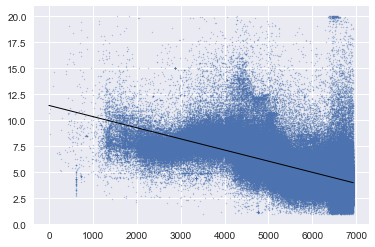

In [53]:
# Plot regression line
plt.scatter(X, y, marker='.', s=5, alpha=0.3)
plt.plot(prediction_space, y_pred, color='black', linewidth=1)
plt.show()

### train_test_split


[[-0.0011]] [11.4118]
R^2: 0.4010656380501255
Root Mean Squared Error (test): 1.6749711084771304
Root Mean Squared Error (train): 1.657199599897369


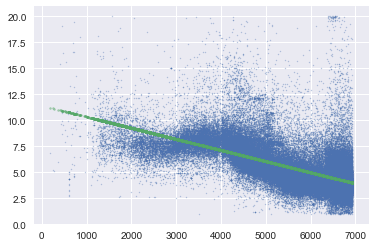

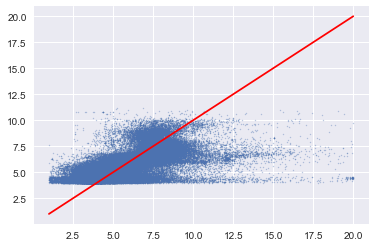

In [54]:
# for now stick with 1 feature

X = dfMod[['num_days']].values
y = dfMod.cost_per_watt.values.reshape(-1, 1)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=0)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# print coefficient and intercept
print(reg_nDays.coef_, reg_nDays.intercept_)
# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (test): {}".format(rmse_test))

rmse_train = np.sqrt(mean_squared_error(y_train, reg_nDays.predict(X_train)))
print("Root Mean Squared Error (train): {}".format(rmse_train))

# actual and predicted vs X
plt.scatter(X_test[:,0], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,0], y_pred, s=4, alpha=0.5)
plt.show();
# actual and predicted vs X
plt.scatter(y_test, y_pred, marker='.', s=5, alpha=0.3)
plt.plot([1, 20], [1, 20], color='red')
plt.show()

[[ 0.0000e+00 -7.4507e-05 -1.0146e-07]] [9.182]
R^2: 0.4127289896095605
Root Mean Squared Error (test): 1.6463234357688863
Root Mean Squared Error (train): 1.6537578904824093


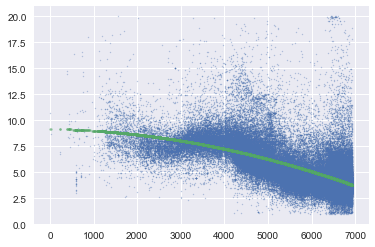

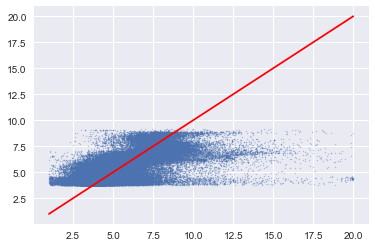

In [55]:
# for now stick with 1 feature, but go poly, ax**2 + b*x + c

# Import necessary modules
# from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures

# these are needed; sklearn wants y as column vector and X as feature matrix
# think this will be the right shape
Xraw = dfMod[['num_days']].values
y = dfMod.cost_per_watt.values.reshape(-1, 1)

poly = PolynomialFeatures(degree=2)
Xpoly = poly.fit_transform(X)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xpoly, y, test_size = 0.30, random_state=42)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# print coefficient and intercept
print(reg_nDays.coef_, reg_nDays.intercept_)
# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (test): {}".format(rmse_test))

rmse_train = np.sqrt(mean_squared_error(y_train, reg_nDays.predict(X_train)))
print("Root Mean Squared Error (train): {}".format(rmse_train))

# actual and predicted vs X
plt.scatter(X_test[:,1], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,1], y_pred, s=4, alpha=0.5)
plt.show();

# actual and predicted vs X
plt.scatter(y_test, y_pred, marker='.', s=5, alpha=0.3)
plt.plot([1, 20], [1, 20], color='red')
plt.show()

[[ 0.0000e+00  5.5682e-03 -1.4550e-06  1.0001e-10]] [2.1635]
R^2: 0.4246441501662235
Root Mean Squared Error (test): 1.6416704153577646
Root Mean Squared Error (train): 1.6226524140731131


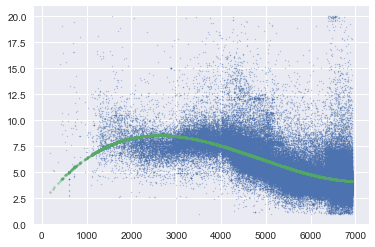

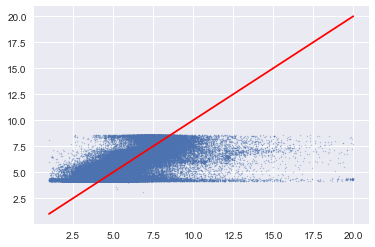

In [56]:
# 1 feature, cubic model

Xraw = dfMod[['num_days']].values
y = dfMod.cost_per_watt.values.reshape(-1, 1)

poly = PolynomialFeatures(degree=3)
Xpoly = poly.fit_transform(Xraw)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xpoly, y, test_size = 0.30, random_state=0)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# print coefficient and intercept
print(reg_nDays.coef_, reg_nDays.intercept_)
# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (test): {}".format(rmse_test))

rmse_train = np.sqrt(mean_squared_error(y_train, reg_nDays.predict(X_train)))
print("Root Mean Squared Error (train): {}".format(rmse_train))

# actual and predicted vs X
plt.scatter(X_test[:,1], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,1], y_pred, s=4, alpha=0.5)
plt.show();

#  predicted vs actual
plt.scatter(y_test, y_pred, marker='.', s=5, alpha=0.3)
plt.plot([1, 20], [1, 20], color='red')
plt.show()

[[ 0.0000e+00 -7.1843e-03  3.7053e-06 -7.5125e-10  4.9321e-14]] [12.6328]
R^2: 0.43725509729974155
Root Mean Squared Error (test): 1.6235792425099775
Root Mean Squared Error (train): 1.6057907367563198


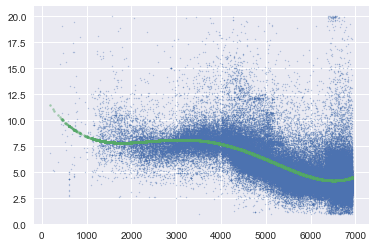

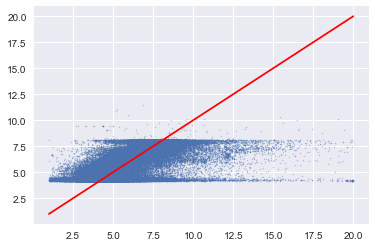

In [57]:
# 1 feature, degree 4 model

Xraw = dfMod[['num_days']].values
y = dfMod.cost_per_watt.values.reshape(-1, 1)

poly = PolynomialFeatures(degree=4)
Xpoly = poly.fit_transform(Xraw)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xpoly, y, test_size = 0.30, random_state=0)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# print coefficient and intercept
print(reg_nDays.coef_, reg_nDays.intercept_)
# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (test): {}".format(rmse_test))

rmse_train = np.sqrt(mean_squared_error(y_train, reg_nDays.predict(X_train)))
print("Root Mean Squared Error (train): {}".format(rmse_train))

# actual and predicted vs X
plt.scatter(X_test[:,1], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,1], y_pred, s=4, alpha=0.5)
plt.show();

#  predicted vs actual
plt.scatter(y_test, y_pred, marker='.', s=5, alpha=0.3)
plt.plot([1, 20], [1, 20], color='red')
plt.show()

[[ 0.0000e+00 -3.3209e-11 -3.9961e-08  1.5467e-10 -5.4115e-14  4.5128e-18]] [7.6535]
R^2: 0.43507899778516484
Root Mean Squared Error (test): 1.6267153535898284
Root Mean Squared Error (train): 1.6083060087492682


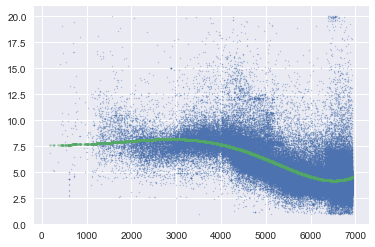

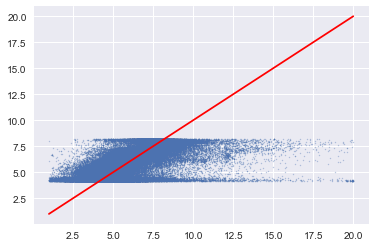

In [58]:
# 1 feature, 5th degree

Xraw = dfMod[['num_days']].values
y = dfMod.cost_per_watt.values.reshape(-1, 1)

poly = PolynomialFeatures(degree=5)
Xpoly = poly.fit_transform(Xraw)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xpoly, y, test_size = 0.30, random_state=0)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# print coefficient and intercept
print(reg_nDays.coef_, reg_nDays.intercept_)
# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (test): {}".format(rmse_test))

rmse_train = np.sqrt(mean_squared_error(y_train, reg_nDays.predict(X_train)))
print("Root Mean Squared Error (train): {}".format(rmse_train))

# actual and predicted vs X
plt.scatter(X_test[:,1], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,1], y_pred, s=4, alpha=0.5)
plt.show();

#  predicted vs actual
plt.scatter(y_test, y_pred, marker='.', s=5, alpha=0.3)
plt.plot([1, 20], [1, 20], color='red')
plt.show()

### now do the same stuff as above but add size_kw

R^2: 0.4413504654460879
Root Mean Squared Error: 1.605704407789705


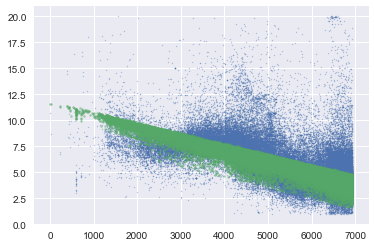

In [59]:
# features: num_days and size_kw

# Import necessary modules
# from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split 

# these are needed; sklearn wants y as column vector and X as feature matrix
# think this will be the right shape
X = dfMod[['num_days', 'size_kw']].values
y = dfMod.cost_per_watt.values.reshape(-1, 1)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

plt.scatter(X_test[:,0], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,0], reg_nDays.predict(X_test), s=4, alpha=0.5)
plt.show();

R^2: 0.4599805790828362
Root Mean Squared Error: 1.5904586947312813
[[ 0.0000e+00  4.2459e-05 -2.9745e-01 -1.0024e-07 -7.5919e-06  1.2728e-02]] [9.952]


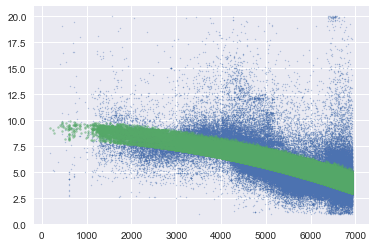

In [60]:
# features: num_days and size_kw, but go poly, ax**2 + b*x + c

# Import necessary modules
# from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures

# these are needed; sklearn wants y as column vector and X as feature matrix
# think this will be the right shape
Xraw = dfMod[['num_days', 'size_kw']].values
y = dfMod.cost_per_watt.values.reshape(-1, 1)

poly = PolynomialFeatures(degree=2)
Xpoly = poly.fit_transform(Xraw)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xpoly, y, test_size = 0.30, random_state=0)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# Compute and print R^2 and RMSE

print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
print(reg_nDays.coef_, reg_nDays.intercept_)

# nice guess here on which piece of X_test to use for plotting!
plt.scatter(X_test[:,1], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,1], reg_nDays.predict(X_test), s=4, alpha=0.5)
plt.show();

R^2: 0.48341523753351096
Root Mean Squared Error: 1.5440688969033707
[[ 0.0000e+00  6.1084e-03 -5.8642e-01 -1.5577e-06 -4.2684e-06  4.7213e-02
   1.0804e-10 -4.3956e-10 -9.0806e-08 -1.0985e-03]] [3.0089]


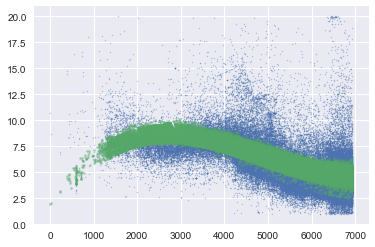

In [61]:
# features: num_days and size_kw, but go poly, 3rd deg

# Import necessary modules
# from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures

# these are needed; sklearn wants y as column vector and X as feature matrix
# think this will be the right shape
Xraw = dfMod[['num_days', 'size_kw']].values
y = dfMod.cost_per_watt.values.reshape(-1, 1)

poly = PolynomialFeatures(degree=3)
Xpoly = poly.fit_transform(Xraw)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xpoly, y, test_size = 0.30, random_state=42)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
print(reg_nDays.coef_, reg_nDays.intercept_)

# nice guess here on which piece of X_test to use for plotting!
plt.scatter(X_test[:,1], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,1], reg_nDays.predict(X_test), s=4, alpha=0.5)
plt.show();

R^2: 0.4947277352742795
Root Mean Squared Error: 1.538439546361492
[[ 0.0000e+00 -6.0327e-03  3.7475e-03  3.6542e-06 -3.9750e-04  5.6152e-02
  -7.7068e-10  5.4192e-08  1.4415e-05 -4.2132e-03  5.1053e-14 -1.7181e-12
  -1.7089e-09  9.6427e-08  6.1118e-05]] [11.8882]


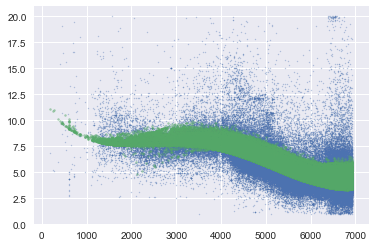

In [62]:
# features: num_days and size_kw, but go poly, 4th degree

# Import necessary modules
# from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures

# these are needed; sklearn wants y as column vector and X as feature matrix
# think this will be the right shape
Xraw = dfMod[['num_days', 'size_kw']].values
y = dfMod.cost_per_watt.values.reshape(-1, 1)

poly = PolynomialFeatures(degree=4)
Xpoly = poly.fit_transform(Xraw)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xpoly, y, test_size = 0.30, random_state=0)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
print(reg_nDays.coef_, reg_nDays.intercept_)

# nice guess here on which piece of X_test to use for plotting!
plt.scatter(X_test[:,1], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,1], reg_nDays.predict(X_test), s=4, alpha=0.5)
plt.show();

R^2: 0.4920457287351393
Root Mean Squared Error: 1.5425171935133397
[[ 0.0000e+00 -3.5736e-09  9.7478e-10  3.2517e-07  1.0143e-06  2.0759e-08
   1.1766e-10 -1.4675e-07  2.3462e-05  1.9317e-07 -6.1462e-14  3.2076e-11
  -3.0378e-10 -1.0331e-06  9.4310e-07  5.4127e-18 -1.8742e-15 -2.4336e-13
   8.2543e-11  7.4460e-09  1.6780e-07]] [7.3249]


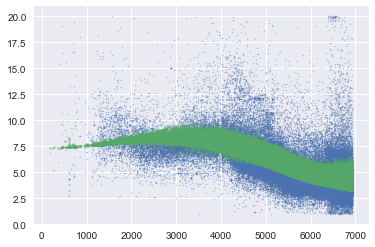

In [63]:
# features: num_days and size_kw, but go poly, 5th degree

# Import necessary modules
# from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures

# these are needed; sklearn wants y as column vector and X as feature matrix
# think this will be the right shape
Xraw = dfMod[['num_days', 'size_kw']].values
y = dfMod.cost_per_watt.values.reshape(-1, 1)

poly = PolynomialFeatures(degree=5)
Xpoly = poly.fit_transform(Xraw)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xpoly, y, test_size = 0.30, random_state=0)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
print(reg_nDays.coef_, reg_nDays.intercept_)

# nice guess here on which piece of X_test to use for plotting!
plt.scatter(X_test[:,1], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,1], reg_nDays.predict(X_test), s=4, alpha=0.5)
plt.show();

### Add in state with dummy vars


In [64]:
dfMod.head()

,num_days,size_kw,state,cost_per_watt,install_date,scaleSize
row_id,,,,,,
1,0,2.2824,CA,10.734315,1998-01-09,0
2,21,1.8504,CA,11.108701,1998-01-30,0
4,26,2.3076,CA,8.667013,1998-02-04,0
6,84,2.3316,CA,13.270286,1998-04-03,0
7,111,0.9300,CA,14.654839,1998-04-30,0


In [65]:
dfModSt = pd.get_dummies(dfMod, drop_first=True)

In [66]:
dfModSt.head()

,num_days,size_kw,cost_per_watt,install_date,scaleSize,state_AZ,state_CA,state_CT,state_DE,state_FL,state_MA,state_MD,state_MN,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OR,state_PA,state_TX,state_VT,state_WI
row_id,,,,,,,,,,,,,,,,,,,,,,,
1,0,2.2824,10.734315,1998-01-09,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,21,1.8504,11.108701,1998-01-30,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,26,2.3076,8.667013,1998-02-04,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,84,2.3316,13.270286,1998-04-03,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,111,0.9300,14.654839,1998-04-30,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
# features: state, num_days and size_kw 

# Import necessary modules
# from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split 

# these are needed; sklearn wants y as column vector and X as feature matrix
# think this will be the right shape
X = dfModSt.drop(['scaleSize', 'cost_per_watt', 'install_date'], axis='columns').values
y = dfModSt.cost_per_watt.values.reshape(-1, 1)

R^2: 0.46100122710043456
Root Mean Squared Error: 1.5772108903880238


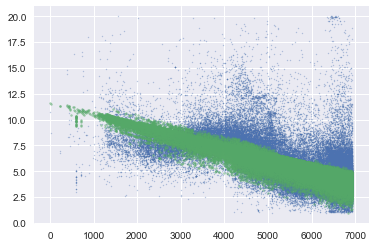

In [68]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

plt.scatter(X_test[:,0], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,0], reg_nDays.predict(X_test), s=4, alpha=0.5)
plt.show();

R^2: 0.4928260386834667
Root Mean Squared Error: 1.5299398372876065
[[-3.4175e-10 -8.2264e-04 -3.5325e-01 -2.8452e+00 -2.5158e+00 -1.3649e+00
  -1.0465e+00 -1.2050e+00 -3.1642e+00 -1.3709e+00 -2.7163e+00 -2.9225e+00
  -2.5696e+00 -3.8910e+00 -2.6829e+00 -2.0510e+00 -1.6802e+00 -1.2723e-01
  -4.1419e+00 -1.5688e+00 -1.2115e+00 -1.2942e-07 -2.3849e-07  1.0479e-03
   1.1565e-03  5.9010e-04  5.7749e-04  6.6724e-04  1.3368e-03  8.3978e-04
   1.3554e-03  1.1143e-03  1.2910e-03  1.5046e-03  1.0632e-03  9.5763e-04
   7.7149e-04  7.0009e-05  1.4883e-03  6.0208e-04  5.4053e-04  1.2905e-02
   5.6783e-02  3.8111e-03  7.9782e-02 -1.3234e-02 -3.4594e-02  2.0589e-02
  -1.2535e-01 -4.0175e-02  5.0219e-02  5.6550e-02  5.2401e-02  3.3710e-02
   1.5703e-02 -4.0101e-03  3.7353e-02  5.7690e-02  4.9168e-02  6.6212e-02
  -2.8452e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.000

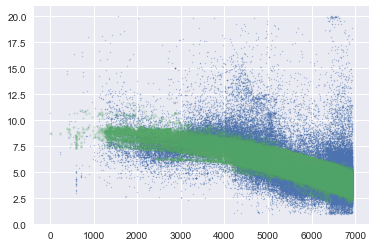

In [69]:
# features: state, num_days and size_kw, but go quadratic

poly = PolynomialFeatures(degree=2)
Xpoly = poly.fit_transform(X)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xpoly, y, test_size = 0.30, random_state=42)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
print(reg_nDays.coef_, reg_nDays.intercept_)

# nice guess here on which piece of X_test to use for plotting!
plt.scatter(X_test[:,1], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,1], reg_nDays.predict(X_test), s=4, alpha=0.2)
plt.show();

R^2: 0.5121879184986362
Root Mean Squared Error: 1.5004521666913835
[[-4.0609e-06  2.8938e-03  2.1618e-01 ...  0.0000e+00  0.0000e+00
  -1.2349e+00]] [7.4597]


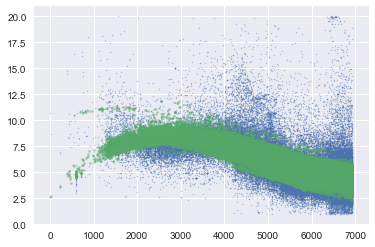

In [70]:
# features: state, num_days and size_kw, but go cubic

poly = PolynomialFeatures(degree=3)
Xpoly = poly.fit_transform(X)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xpoly, y, test_size = 0.30, random_state=42)

# Create the regressor: reg_nDays
reg_nDays = LinearRegression()

# Fit the regressor to the training data
reg_nDays.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_nDays.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
print(reg_nDays.coef_, reg_nDays.intercept_)

# nice guess here on which piece of X_test to use for plotting!
plt.scatter(X_test[:,1], y_test, marker='.', s=5, alpha=0.3)
plt.scatter(X_test[:,1], reg_nDays.predict(X_test), s=4, alpha=0.5)
plt.show();

In [71]:
# how many terms in this thing
reg_nDays.coef_.shape

(1, 1771)

### 4th degree polynomial runs out of memory

Doesn't run on my machine...

In [72]:
# # features: state, num_days and size_kw, but go 4th degree

# poly = PolynomialFeatures(degree=4)
# Xpoly = poly.fit_transform(X)

# # Create training and test sets
# X_train, X_test, y_train, y_test = train_test_split(Xpoly, y, test_size = 0.30, random_state=42)

# # Create the regressor: reg_nDays
# reg_nDays = LinearRegression()

# # Fit the regressor to the training data
# reg_nDays.fit(X_train, y_train)

# # Predict on the test data: y_pred
# y_pred = reg_nDays.predict(X_test)

# # Compute and print R^2 and RMSE
# print("R^2: {}".format(reg_nDays.score(X_test, y_test)))
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print("Root Mean Squared Error: {}".format(rmse))
# print(reg_nDays.coef_, reg_nDays.intercept_)

# # nice guess here on which piece of X_test to use for plotting!
# plt.scatter(X_test[:,1], y_test, marker='.', s=5, alpha=0.3)
# plt.scatter(X_test[:,1], reg_nDays.predict(X_test), s=4, alpha=0.5)
# plt.show();

### cross_val

Cross validate and get average $R^2$.

In [73]:
### first mix it up...
### np.random.shuffle(X)

In [74]:
from sklearn.model_selection import cross_val_score, KFold

In [75]:
# figure out what I'm using
! pip freeze | grep scikit-learn

scikit-learn==0.19.1


You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [76]:
# Create a linear regression object: reg
reg = LinearRegression()

# drive the regressor on the data set and get back R^2
# cv_scores = cross_val_score(reg, X, y, cv=5)
# bad results: [-3.3169 -0.2675 -0.5564 -0.7408 -1.0511]
#              Average 5-Fold CV Score: -1.1865421507164646


# here is the fix for sklearn 0.19.1
kf = KFold(n_splits=5, shuffle=True, random_state=0)
cv_scores = cross_val_score(reg, X, y, cv=kf)

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.4639 0.4581 0.455  0.462  0.4561]
Average 5-Fold CV Score: 0.45902283302774916


In [77]:
reg

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [78]:
dir(reg)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 '_preprocess_data',
 '_set_intercept',
 'copy_X',
 'fit',
 'fit_intercept',
 'get_params',
 'n_jobs',
 'normalize',
 'predict',
 'score',
 'set_params']